# Ensemble Learning

## Initial Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from imblearn.metrics import classification_report_imbalanced
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier

## Read the CSV and Perform Basic Data Cleaning

In [4]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)

# Preview the data
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


## Split the Data into Training and Testing

In [5]:
# Create our features
y = df.loan_status
X = df.drop(columns='loan_status', axis=1)

# Create our target
df.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68817 entries, 0 to 68816
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   home_ownership        68817 non-null  object
 1   verification_status   68817 non-null  object
 2   issue_d               68817 non-null  object
 3   loan_status           68817 non-null  object
 4   pymnt_plan            68817 non-null  object
 5   initial_list_status   68817 non-null  object
 6   next_pymnt_d          68817 non-null  object
 7   application_type      68817 non-null  object
 8   hardship_flag         68817 non-null  object
 9   debt_settlement_flag  68817 non-null  object
dtypes: object(10)
memory usage: 5.3+ MB


In [6]:
X = pd.get_dummies(X, columns=['home_ownership', 'verification_status', 'issue_d', 'pymnt_plan', 'initial_list_status', 'next_pymnt_d', 'application_type', 'hardship_flag', 'debt_settlement_flag'])

In [7]:
# Check the balance of our target values
X.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
0,10500.0,0.1719,375.35,66000.0,27.24,0.0,0.0,8.0,0.0,1609.0,...,1,1,0,1,0,1,1,0,1,1
1,25000.0,0.2000,929.09,105000.0,20.23,0.0,0.0,17.0,1.0,18368.0,...,1,1,0,1,0,1,1,0,1,1
2,20000.0,0.2000,529.88,56000.0,24.26,0.0,0.0,8.0,0.0,13247.0,...,1,1,0,1,0,1,1,0,1,1
3,10000.0,0.1640,353.55,92000.0,31.44,0.0,1.0,10.0,1.0,17996.0,...,1,1,0,1,0,1,1,0,1,1
4,22000.0,0.1474,520.39,52000.0,18.76,0.0,1.0,14.0,0.0,9091.0,...,1,1,0,1,0,1,1,0,1,1


In [8]:
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [9]:
# Split the X and y into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=1,
                                                    stratify=y
)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [10]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [11]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = scaler.fit(X_train)

In [12]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [13]:
# Resample the training data with the BalancedRandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)
rf_model = rf_model.fit(X_train_scaled, y_train)
rf_predictions = rf_model.predict(X_test_scaled)

In [14]:
# Calculated the balanced accuracy score
acc_score = accuracy_score(y_test, rf_predictions)
cm_rf = confusion_matrix(y_test, rf_predictions)
cm_rf_df = pd.DataFrame(
    cm_rf, index=['Actual 0', 'Actual 1'], columns=['predicted 0', 'predicted 1']
)

In [15]:
# Display the confusion matrix
print('Confusion Matrix')
display(cm_rf_df)
print(f'Accuracy Score : {acc_score}')
print('Classification Report')
print(classification_report(y_test, rf_predictions))

Confusion Matrix


,predicted 0,predicted 1
Actual 0,30,57
Actual 1,11,17107


Accuracy Score : 0.9960476605637896
Classification Report
              precision    recall  f1-score   support

   high_risk       0.73      0.34      0.47        87
    low_risk       1.00      1.00      1.00     17118

    accuracy                           1.00     17205
   macro avg       0.86      0.67      0.73     17205
weighted avg       1.00      1.00      1.00     17205



In [16]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, rf_predictions))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.73      0.34      1.00      0.47      0.59      0.32        87
   low_risk       1.00      1.00      0.34      1.00      0.59      0.37     17118

avg / total       1.00      1.00      0.35      1.00      0.59      0.37     17205



In [17]:
# List the features sorted in descending order by feature importance
importances = rf_model.feature_importances_
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

#personal challenge: trying to put all top 10~ highest importance features in a df to vizualize

[(0.08758715176950288, 'total_rec_prncp'),
 (0.07770386368390605, 'total_pymnt'),
 (0.0668123203275906, 'total_pymnt_inv'),
 (0.06459395200819652, 'last_pymnt_amnt'),
 (0.05039235474187962, 'total_rec_int'),
 (0.02136336078215045, 'out_prncp_inv'),
 (0.021208274791883988, 'installment'),
 (0.01897321061620999, 'out_prncp'),
 (0.01626915816044429, 'dti'),
 (0.015749878157203166, 'total_bal_ex_mort'),
 (0.015582867584390167, 'mo_sin_old_rev_tl_op'),
 (0.01453797246616538, 'total_rec_late_fee'),
 (0.014132027435623728, 'avg_cur_bal'),
 (0.014110841747070672, 'max_bal_bc'),
 (0.013983181108134525, 'revol_bal'),
 (0.013859883554018463, 'mo_sin_old_il_acct'),
 (0.013841987813126443, 'bc_util'),
 (0.01380522133571516, 'loan_amnt'),
 (0.013366877033695225, 'bc_open_to_buy'),
 (0.013079969483511075, 'annual_inc'),
 (0.012834266696655773, 'total_acc'),
 (0.012790627140451788, 'il_util'),
 (0.012705207421490807, 'total_bc_limit'),
 (0.012676428851197146, 'int_rate'),
 (0.012558618571945594, 'tot_

In [18]:
importances_df = pd.DataFrame(
    (rf_model.feature_importances_, X.columns)
)
importances_df = importances_df.T
importances_df.columns = ['Importance', 'Feature']

In [19]:
importances_df = importances_df.sort_values(["Importance"], ascending=False).reset_index(drop=True)
importances_df.head()

,Importance,Feature
0,0.087587,total_rec_prncp
1,0.077704,total_pymnt
2,0.066812,total_pymnt_inv
3,0.064594,last_pymnt_amnt
4,0.050392,total_rec_int


In [20]:
importances_df.drop(index=importances_df.iloc[10:, :].index.tolist(), inplace=True)
importances_df

,Importance,Feature
0,0.087587,total_rec_prncp
1,0.077704,total_pymnt
2,0.066812,total_pymnt_inv
3,0.064594,last_pymnt_amnt
4,0.050392,total_rec_int
5,0.021363,out_prncp_inv
6,0.021208,installment
7,0.018973,out_prncp
8,0.016269,dti
9,0.01575,total_bal_ex_mort


In [21]:
importances_df.set_index(('Feature'), inplace=True)

<AxesSubplot:title={'center':'Features Importances'}, ylabel='Feature'>

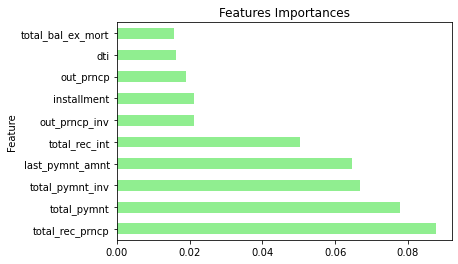

In [22]:
importances_df.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

### Easy Ensemble Classifier

In [27]:
# Train the Classifier
eec_model = EasyEnsembleClassifier(n_estimators=100, random_state=1)
eec_model = eec_model.fit(X_train_scaled, y_train)
eec_y_predictions = eec_model.predict(X_test_scaled)

In [28]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, eec_y_predictions)

0.9254565671948463

In [29]:
# Display the confusion matrix
confusion_matrix(y_test, eec_y_predictions)

array([[   79,     8],
       [  978, 16140]], dtype=int64)

In [30]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, eec_y_predictions, digits=4))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk     0.0747    0.9080    0.9429    0.1381    0.9253    0.8532        87
   low_risk     0.9995    0.9429    0.9080    0.9704    0.9253    0.8591     17118

avg / total     0.9948    0.9427    0.9082    0.9662    0.9253    0.8591     17205



### Final Questions

1. Which model had the best balanced accuracy score?

    Random Forrest Test

2. Which model had the best recall score?

    Random Forrest Test of 1.0

3. Which model had the best geometric mean score?

    Easy Ensemble Classifier of 0.9253

4. What are the top three features?

    total_recovered_principle, total_payment, total_payment_inv 